# KD Tree for Bottleneck TSP

In [1]:
%load_ext autoreload
%autoreload 2

## Load Spotify Data

In [2]:
import tekore as tk
from smoothify.features import construct_features
import numpy as np


In [3]:
ACCESS_TOKEN = "BQAziu6exc-pHSjAh0tMuqWov1XZWCFzzDuSfsHNqSBpivBXO6dY11w_7syX3AXwfCpE_sXJeq5Cf2YtHwUFGOhpaIbT_XcX0Dgwuz7MfmNXj4A8LL5cDJupkN_vKR6Q3UXXuIBxIJRoRdITcqJDIhozZaUPelJtF3lcf0iKRuY"
spotify = tk.Spotify(ACCESS_TOKEN, asynchronous=True, max_limits_on=True, chunked_on=True)

### Fetch current user's tracks

In [4]:
saved_tracks_page = await spotify.saved_tracks()
track_list = [track.track async for track in spotify.all_items(saved_tracks_page)]

### Query Spotify API for audio features

In [5]:
# Extract track IDs so we can fetch additional info
track_id_list = [track.id for track in track_list]
# Get track audio features
track_features_list = await spotify.tracks_audio_features(track_id_list)

### Construct & normalize audio features

In [6]:
features_df = construct_features(audio_features_list=track_features_list)
features_df.head(3)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.947397,0.238924,0.167693,-0.356577,-0.707526,1.618047,-0.616321,1.523571,0.219329
1,-0.257558,0.831977,0.103641,-0.608201,0.011037,1.516056,-0.451466,-1.529047,0.137302
2,-1.324805,1.508168,1.935640,3.608778,-0.707728,-0.801763,1.242168,-0.130478,2.193492


In [7]:
points = np.array(features_df)

## Compute the best path through the points

In [8]:
import random
import multiprocessing
from functools import partial

import pandas as pd
import scipy.spatial
from scipy.spatial import cKDTree
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
sns.set_theme()

from typing import List, Tuple

In [9]:
class KDTreeBottleneckTSP:
    def __init__(self, *, points: np.ndarray):
        self.points = points
        self.num_points = self.points.shape[0]

    def build_tree(self) -> cKDTree:
        tree = cKDTree(self.points)
        return tree

    def greedy_nearest_path(self, tree: cKDTree, source: int) -> Tuple[List[int], float]:
        """
        Starting from the source node, construct a list of node indices by
        iteratively adding the nearest neighbor in the KD Tree.
        """
        current = source  # The node we're currently at
        visited = {source}  # Set of visited indices
        path = [source]  # The path so far (in order)
        max_dist = 0  # Length of the longest edge in the path

        # Loop until we've visited every point
        for i in range(self.num_points):
            # Start with the closest neighbor, keep incrementing until we find an unvisited neighbor
            for k in range(2, self.num_points):
                # Try to get the closes unvisited neighbor to the current node
                (distance,), (candidate_point,) = tree.query(self.points[current], k=[k])
                if candidate_point not in visited:  # Once an unvisited nearest neighbor is found
                    current = candidate_point  # Move to the neighbor node
                    visited.add(candidate_point)  # Mark the neighbor node as visited
                    path.append(candidate_point)  # Add the neighbor node to the path
                    found_unvisited_neighbor = True
                    if distance > max_dist:
                        max_dist = distance  # Update the maximum edge length in the page
                    break
        return path, max_dist

    def get_best_path(self):
        tree = self.build_tree()

        with multiprocessing.Pool(multiprocessing.cpu_count() - 2) as pool:
            tasks = pool.imap(
                partial(self.greedy_nearest_path, tree),
                range(self.num_points),
                chunksize=4
            )
            paths, max_dists = zip(*(task for task in tqdm(tasks, total=self.num_points)))
            best_path_idx = np.argmin(max_dists)
            best_path = paths[best_path_idx]
            min_max_dist = max_dists[best_path_idx]
            return dict(
                paths=paths,
                max_dists=max_dists,
                best_path_idx=best_path_idx,
                best_path=best_path,
                min_max_dist=min_max_dist,
            )

In [10]:
optimizer = KDTreeBottleneckTSP(points=points)
results = optimizer.get_best_path()
best_path = results["best_path"]
max_dist = results["min_max_dist"]
print(f"Max edge length: {max_dist}")
print(best_path)

100%|█████████████████████████████████████████████████████████████████████████████████| 490/490 [00:13<00:00, 35.18it/s]

Max edge length: 5.046747347877011
[365, 369, 111, 441, 225, 115, 47, 172, 49, 364, 393, 224, 144, 180, 181, 376, 205, 154, 131, 104, 301, 267, 343, 272, 287, 276, 379, 53, 201, 63, 266, 305, 438, 248, 359, 178, 306, 268, 420, 94, 398, 134, 41, 122, 86, 39, 338, 129, 404, 48, 332, 283, 303, 229, 142, 328, 458, 133, 75, 347, 74, 25, 345, 273, 228, 298, 295, 206, 99, 355, 159, 150, 90, 385, 168, 110, 473, 170, 92, 471, 323, 377, 132, 65, 195, 254, 218, 234, 191, 315, 316, 330, 20, 116, 292, 167, 474, 465, 199, 450, 193, 221, 339, 308, 342, 426, 462, 309, 242, 405, 176, 430, 0, 481, 357, 213, 204, 165, 362, 67, 214, 23, 70, 166, 440, 457, 232, 223, 1, 356, 477, 331, 197, 62, 58, 399, 318, 106, 56, 175, 373, 304, 15, 190, 26, 476, 22, 14, 89, 87, 463, 282, 270, 93, 445, 407, 483, 216, 435, 28, 64, 428, 329, 468, 294, 102, 335, 263, 207, 375, 322, 29, 386, 46, 459, 32, 37, 235, 105, 432, 387, 231, 215, 444, 31, 9, 30, 44, 470, 464, 262, 187, 336, 419, 333, 383, 146, 319, 59, 439, 151, 76, 2

<AxesSubplot:>

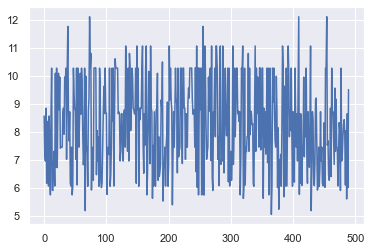

In [11]:
sns.lineplot(data=(results["max_dists"]))